<a href="https://colab.research.google.com/github/glinerosuarez/houndex/blob/master/Dog_breed_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

## Imports

In [0]:
!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

!pip install requests

In [0]:
import os
import re
import time
import json
import glob
import shutil 
import pprint
import random 
import tarfile
import pandas as pd
import tensorflow as tf
from requests import get
from pathlib import Path
from google.colab import auth
import xml.etree.ElementTree as ET

## Tensorflow models

Tensorflow models repo contains necessary scripts to build our pipeline.  

In [0]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 31049 (delta 2), reused 12 (delta 0), pack-reused 31035
Receiving objects: 100% (31049/31049), 510.62 MiB | 36.18 MiB/s, done.
Resolving deltas: 100% (19555/19555), done.
Checking out files: 100% (3055/3055), done.


In [0]:
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


Define environment variables and run setup scripts 

In [0]:
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection/'

In [0]:
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/model_lib_test.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_test.py -> build/lib/object_detection
copying object_detection/eval_util.py -> build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/exporter.py -> build/lib/object_detection
copying object_detection/model_lib.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/exporter_test.py -> build/lib/object_detection
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/model_lib_v2_test.py -> build/lib/object_detection
copying object_detection/__init__.py

Run tests for our setup and verify that everything is ok

In [0]:
shutil.copytree(
    str(Path()/'slim'/'nets'),
    '/usr/local/lib/python3.6/dist-packages/nets'
)

!python object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.8: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul
[ RUN  

## TPU accelerator 

Check if TPU configurations are working properly

In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.8.190.58:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 16921620907670591150),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3510867288018355761),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1121383572719309462),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3528402066246525388),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13029304364103586969),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 1488127083696393181),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 15522609495671751211),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 17427118369884603402),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 2224905720826

In order to use TPU to train our model, it is required to store our data on a Google Cloud Bucket 

In [0]:
%cd /content

auth.authenticate_user()

bucket = "" #@param {type:"string"}

assert bucket, 'Must specify an existing GCS bucket name'
print(f'Using bucket: {bucket}')

model_dir = f'gs://{bucket}/houndex'
print(f'Using model dir: {model_dir}')

# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

# Upload credentials to TPU.
with tf.Session(TPU_WORKER) as sess:    
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)

/content
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Using bucket: staging.apparent-50855.appspot.com
Using model dir: gs://staging.apparent-50855.appspot.com/houndex


# Create TF Records

## Download images dataset and annotations

In [0]:
IMAGES_SET = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
ANNOTATIONS_SET = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

def extract_tar(tar_file):
  tar = tarfile.open(tar_file)
  tar.extractall()
  tar.close()
  tar_file.unlink()

root_path = Path('/content')
images_tar_path = root_path/'images.tar'
annotations_tar_path = root_path/'annotations.tar'

download(IMAGES_SET, images_tar_path)
download(ANNOTATIONS_SET, annotations_tar_path)

extract_tar(images_tar_path)
extract_tar(annotations_tar_path)

## Structure data

Define CsvCreator which we'll use to create a CSV file containing a row for each annotation 

In [0]:
class CsvCreator:

  def __init__(self):
    self.train_data_list = []
    self.eval_data_list = []

  def get_data_from_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for member in root.findall('object'):
      xml_name = root.find('filename').text
      name = xml_name if len(xml_name)>5 else xml_path.stem
      return (
          name+'.jpg',
          int(root.find('size')[0].text),
          int(root.find('size')[1].text),
          member[0].text,
          int(member[4][0].text),
          int(member[4][1].text),
          int(member[4][2].text),
          int(member[4][3].text)
          )
      
  def add_train_data_from_xml(self, xml_path):
    value = CsvCreator.get_data_from_xml(xml_path)
    self.train_data_list.append(value)

  def add_eval_data_from_xml(self, xml_path):
    value = CsvCreator.get_data_from_xml(xml_path)
    self.eval_data_list.append(value)

  def create(data, path):
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(data, columns=column_name)
    xml_df.to_csv(path, index=None)

  def create_train(self, path):
    CsvCreator.create(self.train_data_list, path/'train_labels.csv')

  def create_eval(self, path):
    CsvCreator.create(self.eval_data_list, path/'eval_labels.csv')

Create train and eval directories with 80% and 20% of the images respectively and a CSV file containing the annotations data for each set.

In [0]:
def make_dir(path):
  path.mkdir(parents = True, exist_ok = True)
  return path

def copy_image(image, org_dir_path, train=True):
  image_path = Path(image)
  ann_path = annotations_dir/org_dir_path.stem/image_path.stem
  if train:
    dest_dir_path = train_set_dir
    csv_creator.add_train_data_from_xml(ann_path)
  else:
    dest_dir_path = eval_set_dir
    csv_creator.add_eval_data_from_xml(ann_path)
  shutil.copyfile(image_path, dest_dir_path/image_path.name)

images_dir = root_path/'Images'
annotations_dir = root_path/'Annotation'
sets_dir = root_path/'sets'
eval_set_dir = make_dir(sets_dir/'eval')
train_set_dir = make_dir(sets_dir/'train')
csv_creator = CsvCreator()

for _dir in images_dir.iterdir():
  images  = glob.glob(str(_dir) + '/*.jpg')
  eval_split_size = int(len(images) * 0.2)
  for _ in range(eval_split_size):
    selected_image = random.choice(images)
    images.remove(selected_image)
    copy_image(selected_image, _dir, False)

  for i in range(len(images)):
    copy_image(images[i], _dir)

csv_creator.create_train(train_set_dir)
csv_creator.create_eval(eval_set_dir)

## Run scripts

On this project [repo](https://github.com/glinerosuarez/houndex) I uploaded a script to generate tf records, it is based on the [generate_tfrecord.py script from Dat Tran’s raccoon detector](https://github.com/datitran/raccoon_dataset), this program takes a path to the annotations data csv and a path to the images directory. 

In [0]:
!git clone https://github.com/glinerosuarez/houndex.git

train_labels_csv = str(train_set_dir/'train_labels.csv')

!python houndex/generate_tfrecord.py --csv_input={train_labels_csv} \
  --image_dir={str(train_set_dir)} \
  --output_path=train.record
!python houndex/generate_tfrecord.py --csv_input={str(eval_set_dir/'eval_labels.csv')} \
  --image_dir={str(eval_set_dir)} \
  --output_path=test.record

Cloning into 'houndex'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 21 (delta 10), reused 12 (delta 5), pack-reused 0
Unpacking objects: 100% (21/21), done.
Successfully created the TFRecords: /content/train.record
Successfully created the TFRecords: /content/test.record


# Create label map

In [0]:
!python houndex/generate_label_map.py \
  --labels_csv={train_labels_csv} \
  --output_path=label_map.pbtxt

# Upload data to Google Cloud

In [0]:
!gsutil cp /content/train.record {model_dir}
!gsutil cp /content/test.record {model_dir}
!gsutil cp /content/label_map.pbtxt {model_dir}

Copying file:///content/train.record [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/604.7 MiB.                                    
Copying file:///content/test.record [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/145.5 MiB.                                  

# Download pretrained model

In [0]:
MODEL = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = model_dir + '/models'

download(DOWNLOAD_BASE + MODEL_FILE, f'/content/{MODEL_FILE}')
extract_tar(Path(MODEL_FILE))

!gsutil cp {MODEL}/model.ckpt.* {DEST_DIR}

# Create config file

In [0]:
SAMPLE_CONFIG = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config'
config_path = Path()/'models'/'research'/'object_detection'/'samples'/'configs'/SAMPLE_CONFIG
config_new_path = Path()/SAMPLE_CONFIG
shutil.copyfile(config_path, config_new_path)

CONFIG_FILE = str(config_new_path.absolute())

LABEL_MAP_FILE_NAME = 'label_map.pbtxt'
TRAIN_RECORD_FILE_NAME = 'train.record'
VAL_RECORD_FILE_NAME = 'test.record'

#This is the number of classes your model will detect.
NUM_CLASSES = 120
#This is where the pretrained model is located.
MODEL_CKPT = model_dir + '/models/model.ckpt'
TRAIN_RECORD_PATH = model_dir + '/' + TRAIN_RECORD_FILE_NAME
VAL_RECORD_PATH = model_dir + '/' + VAL_RECORD_FILE_NAME
LABEL_MAP_PATH = model_dir + '/' + LABEL_MAP_FILE_NAME

def sub_n_check(regex, new_str, string):
  s, changes = re.subn(regex, new_str, string)
  if changes:
    print(f'{new_str} was replaced {changes} times in string')
    return s
  else:
    raise ValueError(f'0 matches for regex: {regex} in string: {new_str}')

with open(CONFIG_FILE) as f:
  s = f.read()
with open(CONFIG_FILE, 'w') as f:
  s = sub_n_check('num_classes: 90', f'num_classes: {NUM_CLASSES}', s)
  s = sub_n_check('PATH_TO_BE_CONFIGURED/model.ckpt', MODEL_CKPT, s)
  s = sub_n_check(
      'PATH_TO_BE_CONFIGURED/mscoco_train.record-00000-of-00100', 
      TRAIN_RECORD_PATH, 
      s
  )
  s = sub_n_check(
      'PATH_TO_BE_CONFIGURED/mscoco_val.record-00000-of-00010', 
      VAL_RECORD_PATH, 
      s
  )
  s = sub_n_check(
      'PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', 
      LABEL_MAP_PATH, 
      s
  )
  f.write(s)

num_classes: 120 was replaced 1 times in string
gs://staging.apparent-50855.appspot.com/houndex/models/model.ckpt was replaced 1 times in string
gs://staging.apparent-50855.appspot.com/houndex/train.record was replaced 1 times in string
gs://staging.apparent-50855.appspot.com/houndex/test.record was replaced 1 times in string
gs://staging.apparent-50855.appspot.com/houndex/label_map.pbtxt was replaced 2 times in string


# Train

In [0]:
!python models/research/object_detection/model_tpu_main.py \
    --gcp_project={TPU_WORKER} \
    --num_train_steps=50000 \
    --pipeline_config_path={CONFIG_FILE} \
    --model_dir={DEST_DIR} \
    --alsologtostderr

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1005 02:06:29.234131 140044792022912 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1005 02:06:29.239277 140044792022912 deprecation_wrapper.py:119] From /content/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1005 02:06:29.239527 140044792022912 model_lib.py:617] Forced number of epochs for all eval validations to be 1.

W1005 02:06:29.239681 140044792022912 deprecation_wrapper.py:119] From /con

# Evaluate

In [0]:
!python models/research/object_detection/model_main.py \
    --pipeline_config_path={CONFIG_FILE} \
    --model_dir={DEST_DIR} \
    --run_once=True \
    --checkpoint_dir={DEST_DIR} \
    --logtostderr \

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1005 04:06:51.507633 140243626645376 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1005 04:06:51.512279 140243626645376 deprecation_wrapper.py:119] From /content/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1005 04:06:51.512456 140243626645376 model_lib.py:617] Forced number of epochs for all eval validations to be 1.

W1005 04:06:51.512589 140243626645376 deprecation_wrapper.py:119] From /con

# Set up Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-10-05 04:21:37--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.212.234.252, 52.205.47.13, 52.2.145.235, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.212.234.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  12.98M  40.4MB/s    in 0.3s    

2019-10-05 04:21:37 (40.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(DEST_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"



https://76e84b32.ngrok.io


# Create inference graph

Here we copy the last checkpoint to a new directory  

In [0]:
#@title Number of epochs of the last checkpoint
last_ckpt = "50000" #@param {type:"string"}

TRAINED_MODEL_DIR = f'{model_dir}/trained_model'
LAST_MODEL_CKPT = f'{DEST_DIR}/model.ckpt-{last_ckpt}' 
INF_GRAPH_DIR = model_dir + '/inference_graph'

!gsutil cp {LAST_MODEL_CKPT}.* {TRAINED_MODEL_DIR}

Copying gs://staging.apparent-50855.appspot.com/houndex/models/model.ckpt-50000.data-00000-of-00001...
Copying gs://staging.apparent-50855.appspot.com/houndex/models/model.ckpt-50000.index...
Copying gs://staging.apparent-50855.appspot.com/houndex/models/model.ckpt-50000.meta...
- [3 files][ 65.0 MiB/ 65.0 MiB]                                                
Operation completed over 3 objects/65.0 MiB.                                     


In [0]:
%cd models/research/object_detection

!python export_inference_graph.py \
  --input_type=image_tensor \
  --input_shape=1,300,300,3 \
  --pipeline_config_path={CONFIG_FILE} \
  --trained_checkpoint_prefix={LAST_MODEL_CKPT} \
  --output_directory={INF_GRAPH_DIR}

/content/models/research/object_detection




W1005 16:00:33.598361 139936479172480 deprecation_wrapper.py:119] From export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1005 16:00:33.605895 139936479172480 deprecation_wrapper.py:119] From /content/models/research/object_detection/exporter.py:381: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1005 16:00:35.774322 139936479172480 deprecation_wrapper.py:119] From /content/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W1005 16:00:35.779006 139936479172480 deprecation_wrapper.py:119] From /content/models/research/object_detection/core/preprocessor.py:2660: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W1005 16:00:35.790219 139936479172480 deprecation_wrapper.py:119] From /content/models/research/object_detection/meta

# Test inference

In [0]:
%cd /content/models/research/object_detection/

import sys
import cv2
import zipfile
import numpy as np
import six.moves.urllib as urllib

from io import StringIO
from collections import defaultdict
from distutils.version import StrictVersion

from PIL import Image
from matplotlib import pyplot as plt

sys.path.append("..")
from utils import label_map_util
from utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

# This is needed to display the images.
%matplotlib inline

/content/models/research/object_detection


In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = INF_GRAPH_DIR + '/frozen_inference_graph.pb'

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return cv2.resize(np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8), dsize=(300, 300))

In [0]:
#@title Enter the path of the images for testing the model
test_image1 = "/content/20190720_141515.jpg" #@param {type:"string"}
test_image2 = "/content/20190720_141515 closer.jpg" #@param {type:"string"}
# just add path to the images to the TEST_IMAGE_PATHS.
TEST_IMAGE_PATHS = ['/content/20190720_141515 m.jpg',test_image1, test_image2]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]

  return output_dict

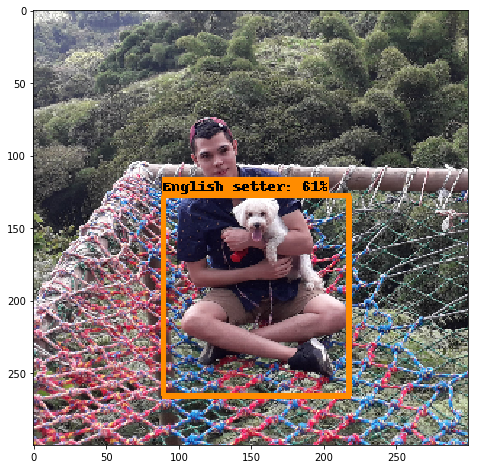

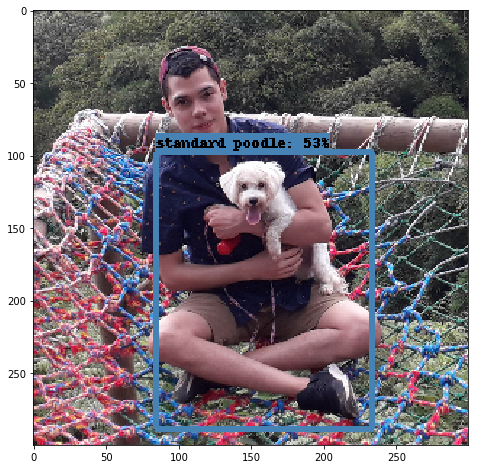

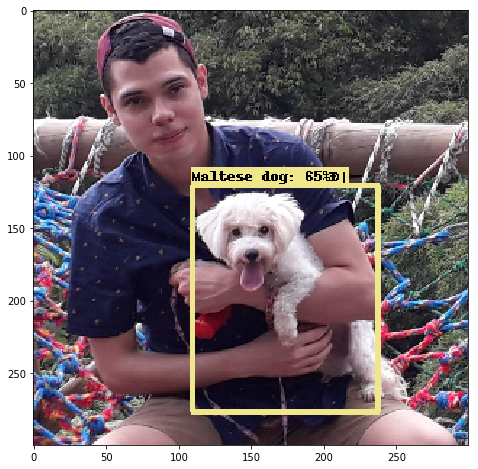

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  im = Image.fromarray(image_np)
  im.save(image_path.split('.')[0] + '-inf.jpg')
  plt.imshow(image_np)

#Get TFLite-compatible model.  

## Export TFlite graph

In [0]:
TFLITE_DIR = model_dir + '/tflite'

!python export_tflite_ssd_graph.py \
    --pipeline_config_path {CONFIG_FILE} \
    --trained_checkpoint_prefix {INF_GRAPH_DIR}/model.ckpt \
    --output_directory {TFLITE_DIR}

In [0]:
TFLITE_GRAPH_PATH = '/content/tflite_graph.pb'
TFLITE_GRAPH_PBTXT_PATH = '/content/tflite_graph.pbtxt'

!gsutil cp {TFLITE_DIR + '/tflite_graph.pb'} {TFLITE_GRAPH_PATH}
!gsutil cp {TFLITE_DIR + '/tflite_graph.pbtxt'} {TFLITE_GRAPH_PBTXT_PATH}

TFLITE_FILE = '/content/detect.tflite'

Copying gs://staging.apparent-50855.appspot.com/houndex/tflite/tflite_graph.pb...
| [1 files][ 28.1 MiB/ 28.1 MiB]                                                
Operation completed over 1 objects/28.1 MiB.                                     
Copying gs://staging.apparent-50855.appspot.com/houndex/tflite/tflite_graph.pbtxt...
| [1 files][ 79.9 MiB/ 79.9 MiB]                                                
Operation completed over 1 objects/79.9 MiB.                                     


## Install Bazel

In [0]:
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list
!curl https://bazel.build/bazel-release.pub.gpg | sudo apt-key add -
!apt-get update && sudo apt-get install bazel

os.environ['PATH'] += ':/usr/bin/bazel'

deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4654  100  4654    0     0  30220      0 --:--:-- --:--:-- --:--:-- 30025
OK
Get:1 https://storage.googleapis.com/bazel-apt stable InRelease [2,464 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/rep

## Generate tflite model

In [0]:
%cd /content
!git clone https://github.com/tensorflow/tensorflow.git
%cd tensorflow

/content
Cloning into 'tensorflow'...
remote: Enumerating objects: 682061, done.
remote: Total 682061 (delta 0), reused 0 (delta 0), pack-reused 682061
Receiving objects: 100% (682061/682061), 387.71 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (553494/553494), done.
Checking out files: 100% (20174/20174), done.
/content/tensorflow


In [0]:
!bazel run -c opt tensorflow/lite/toco:toco -- \
--input_file={TFLITE_GRAPH_PATH} \
--output_file={TFLITE_FILE} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_values=128 \
--change_concat_input_ranges=false \
--allow_custom_ops

Extracting Bazel installation...
Starting local Bazel server and connecting to it...
INFO: Options provided by the client:
  Inherited 'common' options: --isatty=1 --terminal_columns=0
INFO: Reading rc options for 'run' from /content/tensorflow/.bazelrc:
  Inherited 'build' options: --apple_platform_type=macos --define framework_shared_object=true --define open_source_build=true --define=use_fast_cpp_protos=true --define=allow_oversize_protos=true --spawn_strategy=standalone --strategy=Genrule=standalone -c opt --cxxopt=-std=c++14 --host_cxxopt=-std=c++14 --announce_rc --define=grpc_no_ares=true --define=PREFIX=/usr --define=LIBDIR=$(PREFIX)/lib --define=INCLUDEDIR=$(PREFIX)/include
Loading: 0 packages loaded
Loading: 0 packages loaded
Loading: 0 packages loaded
    Fetching @io_bazel_rules_closure; fetching
Loading: 0 packages loaded
Loading: 0 packages loaded
Loading: 0 packages loaded
    Fetching @bazel_toolchains; fetching
Loading: 0 packages loaded
Loading: 0 packages loaded
    

In [0]:
LOCAL_LABEL_MAP_PATH = '/content/label_map.pbtxt'
!gsutil cp {LABEL_MAP_PATH} {LOCAL_LABEL_MAP_PATH} 

Copying gs://staging.apparent-50855.appspot.com/houndex/label_map.pbtxt...
/ [1 files][  8.7 KiB/  8.7 KiB]                                                
Operation completed over 1 objects/8.7 KiB.                                      


In [0]:
%cd /content/models/research/object_detection
%pwd

/content/models/research/object_detection


'/content/models/research/object_detection'

## Create labelmap.txt

In [0]:
from object_detection.utils import label_map_util

label_dict = {
    v:k
    for k,v in label_map_util.get_label_map_dict(
        LOCAL_LABEL_MAP_PATH,use_display_name=True
    ).items()
}

CLASSES_MAP = '/content/labelmap.txt'
with open(CLASSES_MAP, 'w') as f:
  f.write('???' + '\n')
  for i in range(len(label_dict)):
    f.write(label_dict[i+1] + '\n')


In [0]:
%cat {CLASSES_MAP}

In [0]:
!gsutil cp {CLASSES_MAP} {TFLITE_DIR}
!gsutil cp {TFLITE_FILE} {TFLITE_DIR}

Copying file:///content/labelmap.txt [Content-Type=text/plain]...
/ [1 files][  1.7 KiB/  1.7 KiB]                                                
Operation completed over 1 objects/1.7 KiB.                                      
Copying file:///content/detect.tflite [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/7.0 MiB.                                      
